In [1]:
import pandas as pd

def parse_dataset_string(s):
    parts = s.split('/')
    if len(parts) == 2:
        dataset = parts[0]
        freq = None
        term = parts[1]
    elif len(parts) == 3:
        dataset, freq, term = parts
    else:
        raise ValueError(f"Unexpected dataset format: {s}")
    return pd.Series([dataset, freq, term])

In [2]:
def get_df(result_path):
    df = pd.read_csv(result_path)
    df = df[["dataset", "domain", "num_variates", "model", "train_step",
        "eval_metrics/MASE[0.5]", "eval_metrics/mean_weighted_sum_quantile_loss"]]
    df = df.rename(columns={"eval_metrics/MASE[0.5]": "MASE"})
    df = df.rename(columns={"eval_metrics/mean_weighted_sum_quantile_loss": "Qloss"})
    df = df.rename(columns={"train_step": "train step"})

    # Apply the parsing
    df[['dataset_name', 'freq', 'term']] = df['dataset'].apply(parse_dataset_string)

    # Manually fill missing frequencies
    freq_map = {
        'exchange_rate': 'D',
        'ercot': 'H',
        'dominick': 'W'
    }

    df['freq'] = df.apply(lambda row: freq_map.get(row['dataset_name'], row['freq']), axis=1)
    df['freq'] = df['freq'].map({
        "10S": "10 seconds",
        "5T": "5 minutes",
        "10T": "10 minute",
        "H": "1 hour",
        "D": "1 day",
        "W": "1 week",
    })

    df["size"] = df.apply(lambda row: row['model'].split("-")[-1], axis=1)

    df.drop(columns='dataset', inplace=True)

    df = df.rename(columns={"dataset_name": "dataset"})
    df = df[["dataset", "freq", "term", "domain", "num_variates", "model", "size", "train step",
        "MASE", "Qloss"]]
    
    return df

In [3]:
base_df = get_df(result_path = "results/test/chronos_bolt_base_test_results.csv")
small_df = get_df(result_path = "results/test/chronos_bolt_small_test_results.csv")
mini_df = get_df(result_path = "results/test/chronos_bolt_mini_test_results.csv")
tiny_df = get_df(result_path = "results/test/chronos_bolt_tiny_test_results.csv")

In [4]:
df = pd.concat([base_df, small_df, mini_df, tiny_df])

In [5]:
df

,dataset,freq,term,domain,num_variates,model,size,train step,MASE,Qloss
0,exchange_rate,1 day,short,Econ/Fin,1,chronos-bolt-base,base,500,24.251517,0.063937
1,exchange_rate,1 day,medium,Econ/Fin,1,chronos-bolt-base,base,500,20.395774,0.061711
2,exchange_rate,1 day,long,Econ/Fin,1,chronos-bolt-base,base,500,19.877615,0.059450
3,ercot,1 hour,short,Energy,1,chronos-bolt-base,base,500,2.493600,0.161155
4,ercot,1 hour,medium,Energy,1,chronos-bolt-base,base,500,2.703264,0.169326
...,...,...,...,...,...,...,...,...,...,...
900,solar,10 minute,medium,Energy,1,chronos-bolt-tiny,tiny,200000,2.830568,1.418010
901,solar,10 minute,long,Energy,1,chronos-bolt-tiny,tiny,200000,2.772037,1.369096
902,solar,1 hour,short,Energy,1,chronos-bolt-tiny,tiny,200000,3.004985,1.411132
903,solar,1 hour,medium,Energy,1,chronos-bolt-tiny,tiny,200000,3.053877,1.419348


In [6]:
df_long = pd.melt(
    df,
    id_vars=["dataset", "freq", "term", "domain", "num_variates", "model", "size", "train step"],
    value_vars=["MASE", "Qloss"],
    var_name="metric",
    value_name="value"
)


df_pivot = df_long.pivot_table(
    index=["dataset", "freq", "term", "domain", "num_variates", "size", "metric"],
    columns="train step",
    values="value"
).reset_index()

In [7]:
df_pivot.head()

train step,dataset,freq,term,domain,num_variates,size,metric,500,10000,20000,...,110000,120000,130000,140000,150000,160000,170000,180000,190000,200000
0,bitbrains_fast_storage,1 hour,short,Web/CloudOps,2,base,MASE,2.025949,2.197866,2.057820,...,2.074659,2.073307,1.956935,1.935180,1.961362,1.933696,2.074058,2.058190,2.145721,2.064724
1,bitbrains_fast_storage,1 hour,short,Web/CloudOps,2,base,Qloss,1.554958,1.537555,1.550422,...,1.499420,1.510646,1.493720,1.556606,1.510493,1.489478,1.566229,1.510931,1.567561,1.496878
2,bitbrains_fast_storage,1 hour,short,Web/CloudOps,2,mini,MASE,1.901500,2.051663,1.982010,...,1.928380,2.148383,2.316839,2.121807,2.119477,1.985224,1.943896,2.025754,1.974481,2.047939
3,bitbrains_fast_storage,1 hour,short,Web/CloudOps,2,mini,Qloss,1.489185,1.539738,1.462624,...,1.492582,1.564842,1.517571,1.529321,1.517911,1.519590,1.492736,1.471911,1.496896,1.493888
4,bitbrains_fast_storage,1 hour,short,Web/CloudOps,2,small,MASE,1.980415,1.952074,1.958588,...,2.009047,2.256154,2.145661,2.019833,1.998030,2.045786,2.004791,1.985440,2.264403,2.134664


In [8]:
train_step_list = [500] + [i*10_000 for i in range(1, 20+1)]

In [9]:
df_grouped_term = df_pivot.groupby(["term", "size", "metric"])[train_step_list].mean().reset_index()
#df_grouped_term

In [10]:
size_order = ['base', 'small', 'mini', 'tiny']

df_grouped_term['size'] = pd.Categorical(df_grouped_term['size'], categories=size_order, ordered=True)
df_grouped_term = df_grouped_term.sort_values(by=['term', 'size'])

In [11]:
df_grouped_term.columns

Index([  'term',   'size', 'metric',      500,    10000,    20000,    30000,
          40000,    50000,    60000,    70000,    80000,    90000,   100000,
         110000,   120000,   130000,   140000,   150000,   160000,   170000,
         180000,   190000,   200000],
      dtype='object', name='train step')

In [12]:
df_grouped_domain = df_pivot.groupby(["domain", "size", "metric"])[train_step_list].mean().reset_index()
#df_grouped_domain

In [13]:
size_order = ['base', 'small', 'mini', 'tiny']

df_grouped_domain['size'] = pd.Categorical(df_grouped_domain['size'], categories=size_order, ordered=True)
df_grouped_domain = df_grouped_domain.sort_values(by=['domain', 'size'])

In [14]:
df_grouped_freq = df_pivot.groupby(["freq", "size", "metric"])[train_step_list].mean().reset_index()
#df_grouped_freq

In [15]:
size_order = ['base', 'small', 'mini', 'tiny']
freq_order = ['10 seconds', '5 minutes', '10 minute', '1 hour', '1 day', '1 week']

df_grouped_freq['size'] = pd.Categorical(df_grouped_freq['size'], categories=size_order, ordered=True)
df_grouped_freq['freq'] = pd.Categorical(df_grouped_freq['freq'], categories=freq_order, ordered=True)

df_grouped_freq = df_grouped_freq.sort_values(by=['freq', 'size'])

### Tables

In [16]:
print(df_grouped_term[[
    'term', 'size', 'metric', 500, 10000, 20000, 30000, 40000, 50000, 60000
    ]].to_latex(index=False, float_format="%.3f"))

\begin{tabular}{lllrrrrrrr}
\toprule
term & size & metric & 500 & 10000 & 20000 & 30000 & 40000 & 50000 & 60000 \\
\midrule
long & base & MASE & 4.455 & 4.430 & 4.413 & 4.409 & 4.371 & 4.459 & 4.432 \\
long & base & Qloss & 0.632 & 0.625 & 0.633 & 0.619 & 0.622 & 0.622 & 0.631 \\
long & small & MASE & 4.437 & 4.417 & 4.375 & 4.381 & 4.397 & 4.407 & 4.419 \\
long & small & Qloss & 0.628 & 0.625 & 0.622 & 0.619 & 0.622 & 0.618 & 0.626 \\
long & mini & MASE & 4.405 & 4.368 & 4.428 & 4.410 & 4.387 & 4.441 & 4.418 \\
long & mini & Qloss & 0.628 & 0.618 & 0.626 & 0.619 & 0.623 & 0.623 & 0.631 \\
long & tiny & MASE & 4.370 & 4.366 & 4.369 & 4.423 & 4.373 & 4.426 & 4.393 \\
long & tiny & Qloss & 0.617 & 0.620 & 0.623 & 0.628 & 0.625 & 0.627 & 0.622 \\
medium & base & MASE & 4.525 & 4.518 & 4.506 & 4.507 & 4.483 & 4.492 & 4.477 \\
medium & base & Qloss & 0.614 & 0.621 & 0.616 & 0.616 & 0.608 & 0.622 & 0.612 \\
medium & small & MASE & 4.529 & 4.504 & 4.553 & 4.470 & 4.480 & 4.513 & 4.496 \\
medi

In [17]:
print(df_grouped_term[[
    'term', 'size', 'metric', 70000, 80000, 90000, 100000, 110000, 120000, 130000
    ]].to_latex(index=False, float_format="%.3f"))

\begin{tabular}{lllrrrrrrr}
\toprule
term & size & metric & 70000 & 80000 & 90000 & 100000 & 110000 & 120000 & 130000 \\
\midrule
long & base & MASE & 4.381 & 4.429 & 4.421 & 4.401 & 4.333 & 4.409 & 4.385 \\
long & base & Qloss & 0.623 & 0.629 & 0.625 & 0.626 & 0.621 & 0.624 & 0.615 \\
long & small & MASE & 4.444 & 4.401 & 4.468 & 4.447 & 4.425 & 4.430 & 4.477 \\
long & small & Qloss & 0.625 & 0.627 & 0.630 & 0.625 & 0.622 & 0.637 & 0.629 \\
long & mini & MASE & 4.405 & 4.400 & 4.420 & 4.383 & 4.403 & 4.430 & 4.442 \\
long & mini & Qloss & 0.615 & 0.625 & 0.619 & 0.621 & 0.624 & 0.618 & 0.625 \\
long & tiny & MASE & 5.191 & 4.390 & 3.150 & 4.397 & 4.403 & 4.405 & 4.402 \\
long & tiny & Qloss & 0.480 & 0.619 & 0.717 & 0.627 & 0.630 & 0.622 & 0.621 \\
medium & base & MASE & 4.569 & 4.492 & 4.528 & 4.528 & 4.489 & 4.525 & 4.464 \\
medium & base & Qloss & 0.617 & 0.615 & 0.613 & 0.621 & 0.618 & 0.621 & 0.616 \\
medium & small & MASE & 4.581 & 4.556 & 4.518 & 4.544 & 4.525 & 4.577 & 4.553 \

In [18]:
print(df_grouped_term[[
    'term', 'size', 'metric', 140000, 150000, 160000, 170000, 180000, 190000, 200000
    ]].to_latex(index=False, float_format="%.3f"))

\begin{tabular}{lllrrrrrrr}
\toprule
term & size & metric & 140000 & 150000 & 160000 & 170000 & 180000 & 190000 & 200000 \\
\midrule
long & base & MASE & 4.437 & 4.410 & 4.467 & 4.425 & 4.384 & 4.409 & 4.402 \\
long & base & Qloss & 0.628 & 0.626 & 0.627 & 0.632 & 0.623 & 0.617 & 0.620 \\
long & small & MASE & 4.423 & 4.468 & 4.521 & 4.422 & 4.513 & 4.434 & 4.426 \\
long & small & Qloss & 0.624 & 0.625 & 0.621 & 0.627 & 0.637 & 0.622 & 0.630 \\
long & mini & MASE & 4.360 & 4.440 & 4.383 & 4.474 & 4.406 & 4.445 & 4.400 \\
long & mini & Qloss & 0.621 & 0.622 & 0.621 & 0.627 & 0.622 & 0.630 & 0.625 \\
long & tiny & MASE & 4.420 & 4.411 & 4.403 & 4.425 & 4.420 & 4.366 & 4.421 \\
long & tiny & Qloss & 0.617 & 0.622 & 0.626 & 0.623 & 0.629 & 0.617 & 0.621 \\
medium & base & MASE & 4.514 & 4.547 & 4.521 & 4.516 & 4.516 & 4.480 & 4.513 \\
medium & base & Qloss & 0.622 & 0.620 & 0.618 & 0.610 & 0.623 & 0.612 & 0.616 \\
medium & small & MASE & 4.579 & 4.562 & 4.546 & 4.521 & 4.605 & 4.569 & 4.54

In [19]:
print(df_grouped_domain[[
    'domain', 'size', 'metric', 500, 10000, 20000, 30000, 40000, 50000, 60000
    ]].to_latex(index=False, float_format="%.3f"))

\begin{tabular}{lllrrrrrrr}
\toprule
domain & size & metric & 500 & 10000 & 20000 & 30000 & 40000 & 50000 & 60000 \\
\midrule
Econ/Fin & base & MASE & 21.508 & 20.214 & 20.105 & 19.450 & 20.153 & 19.658 & 19.391 \\
Econ/Fin & base & Qloss & 0.062 & 0.060 & 0.061 & 0.059 & 0.059 & 0.059 & 0.059 \\
Econ/Fin & small & MASE & 20.036 & 20.143 & 19.732 & 20.222 & 19.182 & 18.923 & 19.788 \\
Econ/Fin & small & Qloss & 0.060 & 0.061 & 0.059 & 0.059 & 0.058 & 0.057 & 0.059 \\
Econ/Fin & mini & MASE & 19.571 & 19.903 & 19.542 & 19.732 & 20.234 & 20.178 & 20.081 \\
Econ/Fin & mini & Qloss & 0.058 & 0.059 & 0.058 & 0.059 & 0.060 & 0.061 & 0.060 \\
Econ/Fin & tiny & MASE & 19.694 & 19.563 & 19.891 & 20.002 & 19.772 & 19.798 & 19.501 \\
Econ/Fin & tiny & Qloss & 0.059 & 0.059 & 0.060 & 0.059 & 0.060 & 0.059 & 0.060 \\
Energy & base & MASE & 2.560 & 2.574 & 2.634 & 2.534 & 2.539 & 2.577 & 2.594 \\
Energy & base & Qloss & 0.892 & 0.899 & 0.911 & 0.882 & 0.891 & 0.892 & 0.892 \\
Energy & small & MASE &

In [20]:
print(df_grouped_domain[[
    'domain', 'size', 'metric', 70000, 80000, 90000, 100000, 110000, 120000, 130000
    ]].to_latex(index=False, float_format="%.3f"))

\begin{tabular}{lllrrrrrrr}
\toprule
domain & size & metric & 70000 & 80000 & 90000 & 100000 & 110000 & 120000 & 130000 \\
\midrule
Econ/Fin & base & MASE & 19.646 & 19.392 & 19.964 & 20.284 & 19.338 & 19.866 & 19.448 \\
Econ/Fin & base & Qloss & 0.059 & 0.059 & 0.060 & 0.060 & 0.059 & 0.060 & 0.058 \\
Econ/Fin & small & MASE & 19.875 & 19.801 & 19.115 & 20.213 & 19.839 & 19.795 & 21.488 \\
Econ/Fin & small & Qloss & 0.059 & 0.060 & 0.059 & 0.059 & 0.059 & 0.060 & 0.062 \\
Econ/Fin & mini & MASE & 19.871 & 19.775 & 19.749 & 20.153 & 20.061 & 19.976 & 19.810 \\
Econ/Fin & mini & Qloss & 0.059 & 0.059 & 0.060 & 0.060 & 0.060 & 0.059 & 0.059 \\
Econ/Fin & tiny & MASE & 19.666 & 20.003 & NaN & 19.608 & 19.491 & 19.569 & 19.597 \\
Econ/Fin & tiny & Qloss & 0.059 & 0.060 & NaN & 0.059 & 0.059 & 0.059 & 0.059 \\
Energy & base & MASE & 2.561 & 2.625 & 2.589 & 2.568 & 2.572 & 2.548 & 2.539 \\
Energy & base & Qloss & 0.886 & 0.902 & 0.888 & 0.892 & 0.892 & 0.903 & 0.888 \\
Energy & small & MASE 

In [21]:
print(df_grouped_domain[[
    'domain', 'size', 'metric', 140000, 150000, 160000, 170000, 180000, 190000, 200000
    ]].to_latex(index=False, float_format="%.3f"))

\begin{tabular}{lllrrrrrrr}
\toprule
domain & size & metric & 140000 & 150000 & 160000 & 170000 & 180000 & 190000 & 200000 \\
\midrule
Econ/Fin & base & MASE & 19.455 & 19.906 & 19.867 & 20.030 & 19.441 & 19.699 & 19.390 \\
Econ/Fin & base & Qloss & 0.058 & 0.060 & 0.060 & 0.061 & 0.060 & 0.059 & 0.060 \\
Econ/Fin & small & MASE & 19.718 & 19.982 & 19.398 & 19.198 & 19.890 & 18.913 & 19.290 \\
Econ/Fin & small & Qloss & 0.060 & 0.060 & 0.059 & 0.058 & 0.059 & 0.058 & 0.059 \\
Econ/Fin & mini & MASE & 19.254 & 20.516 & 19.200 & 19.519 & 19.284 & 19.572 & 20.010 \\
Econ/Fin & mini & Qloss & 0.059 & 0.061 & 0.060 & 0.060 & 0.059 & 0.061 & 0.060 \\
Econ/Fin & tiny & MASE & 19.687 & 20.011 & 18.991 & 19.468 & 20.017 & 19.908 & 20.001 \\
Econ/Fin & tiny & Qloss & 0.059 & 0.060 & 0.058 & 0.059 & 0.059 & 0.059 & 0.059 \\
Energy & base & MASE & 2.578 & 2.569 & 2.582 & 2.563 & 2.567 & 2.576 & 2.573 \\
Energy & base & Qloss & 0.905 & 0.890 & 0.901 & 0.891 & 0.897 & 0.892 & 0.892 \\
Energy & small

In [22]:
print(df_grouped_freq[[
    'freq', 'size', 'metric', 500, 10000, 20000, 30000, 40000, 50000, 60000
    ]].to_latex(index=False, float_format="%.3f"))

\begin{tabular}{lllrrrrrrr}
\toprule
freq & size & metric & 500 & 10000 & 20000 & 30000 & 40000 & 50000 & 60000 \\
\midrule
10 seconds & base & MASE & 7.889 & 7.842 & 8.009 & 7.982 & 7.829 & 7.988 & 7.879 \\
10 seconds & base & Qloss & 0.117 & 0.116 & 0.116 & 0.114 & 0.114 & 0.114 & 0.116 \\
10 seconds & small & MASE & 7.920 & 7.896 & 7.916 & 7.865 & 7.928 & 8.023 & 8.015 \\
10 seconds & small & Qloss & 0.116 & 0.115 & 0.115 & 0.115 & 0.115 & 0.114 & 0.117 \\
10 seconds & mini & MASE & 7.860 & 7.888 & 7.937 & 7.899 & 7.875 & 7.913 & 8.051 \\
10 seconds & mini & Qloss & 0.115 & 0.116 & 0.115 & 0.116 & 0.116 & 0.116 & 0.115 \\
10 seconds & tiny & MASE & 7.844 & 7.852 & 7.881 & 7.894 & 7.844 & 7.914 & 7.894 \\
10 seconds & tiny & Qloss & 0.115 & 0.114 & 0.114 & 0.114 & 0.115 & 0.115 & 0.116 \\
5 minutes & base & MASE & 2.157 & 2.201 & 2.155 & 2.148 & 2.178 & 2.166 & 2.146 \\
5 minutes & base & Qloss & 0.845 & 0.841 & 0.851 & 0.846 & 0.848 & 0.855 & 0.845 \\
5 minutes & small & MASE & 2.16

In [23]:
print(df_grouped_freq[[
    'freq', 'size', 'metric', 70000, 80000, 90000, 100000, 110000, 120000, 130000
    ]].to_latex(index=False, float_format="%.3f"))

\begin{tabular}{lllrrrrrrr}
\toprule
freq & size & metric & 70000 & 80000 & 90000 & 100000 & 110000 & 120000 & 130000 \\
\midrule
10 seconds & base & MASE & 7.902 & 7.925 & 7.941 & 7.909 & 7.861 & 7.895 & 7.901 \\
10 seconds & base & Qloss & 0.113 & 0.114 & 0.115 & 0.115 & 0.115 & 0.113 & 0.116 \\
10 seconds & small & MASE & 7.966 & 7.867 & 8.006 & 7.933 & 7.898 & 7.973 & 8.000 \\
10 seconds & small & Qloss & 0.114 & 0.115 & 0.118 & 0.116 & 0.114 & 0.117 & 0.115 \\
10 seconds & mini & MASE & 8.007 & 7.918 & 7.927 & 7.936 & 7.963 & 8.248 & 7.924 \\
10 seconds & mini & Qloss & 0.116 & 0.116 & 0.116 & 0.116 & 0.115 & 0.115 & 0.117 \\
10 seconds & tiny & MASE & 7.890 & 7.941 & 7.900 & 7.867 & 7.885 & 7.865 & 7.918 \\
10 seconds & tiny & Qloss & 0.115 & 0.115 & 0.115 & 0.114 & 0.113 & 0.115 & 0.114 \\
5 minutes & base & MASE & 2.177 & 2.124 & 2.177 & 2.190 & 2.140 & 2.162 & 2.142 \\
5 minutes & base & Qloss & 0.851 & 0.847 & 0.847 & 0.853 & 0.847 & 0.850 & 0.843 \\
5 minutes & small & MASE 

In [24]:
print(df_grouped_freq[[
    'freq', 'size', 'metric',  140000, 150000, 160000, 170000, 180000, 190000, 200000
    ]].to_latex(index=False, float_format="%.3f"))

\begin{tabular}{lllrrrrrrr}
\toprule
freq & size & metric & 140000 & 150000 & 160000 & 170000 & 180000 & 190000 & 200000 \\
\midrule
10 seconds & base & MASE & 7.963 & 7.921 & 7.981 & 7.894 & 7.955 & 7.963 & 7.904 \\
10 seconds & base & Qloss & 0.113 & 0.116 & 0.115 & 0.115 & 0.114 & 0.115 & 0.115 \\
10 seconds & small & MASE & 8.044 & 8.035 & 7.981 & 8.148 & 8.030 & 8.141 & 8.054 \\
10 seconds & small & Qloss & 0.115 & 0.116 & 0.118 & 0.116 & 0.113 & 0.113 & 0.116 \\
10 seconds & mini & MASE & 8.019 & 7.929 & 7.963 & 8.043 & 8.124 & 8.021 & 7.924 \\
10 seconds & mini & Qloss & 0.118 & 0.116 & 0.114 & 0.113 & 0.119 & 0.115 & 0.115 \\
10 seconds & tiny & MASE & 7.913 & 7.951 & 7.871 & 7.864 & 7.911 & 7.970 & 8.003 \\
10 seconds & tiny & Qloss & 0.113 & 0.114 & 0.114 & 0.115 & 0.115 & 0.116 & 0.114 \\
5 minutes & base & MASE & 2.172 & 2.218 & 2.174 & 2.154 & 2.173 & 2.189 & 2.164 \\
5 minutes & base & Qloss & 0.848 & 0.855 & 0.845 & 0.855 & 0.849 & 0.844 & 0.845 \\
5 minutes & small & MA

### Baseline

In [25]:
baseline_results = pd.DataFrame()

for model in ["chronos_bolt_base", "chronos_bolt_small", "chronos_bolt_mini", "chronos_bolt_tiny"]:
    tmp_baseline_results = pd.read_csv(f"results/baseline_test/{model}_results.csv")
    chronos_benchmark = pd.read_csv("results/baseline_test/chronos_benchmark_results.csv")
    chronos_benchmark = chronos_benchmark[chronos_benchmark["model"] == model]
    tmp_baseline_results = pd.concat([tmp_baseline_results, chronos_benchmark])

    baseline_results = pd.concat([baseline_results, tmp_baseline_results])

In [26]:
def parse_dataset_string(s):
    parts = s.split('/')
    if len(parts) == 2:
        dataset = parts[0]
        freq = None
        term = parts[1]
    elif len(parts) == 3:
        dataset, freq, term = parts
    else:
        raise ValueError(f"Unexpected dataset format: {s}")
    return pd.Series([dataset, freq, term])

# Manually fill missing frequencies
freq_map = {
    'exchange_rate': 'D',
    'ercot': 'H',
    'dominick': 'W'
}

In [27]:
baseline_results = baseline_results[["dataset", "domain", "num_variates", "model",
    "eval_metrics/MASE[0.5]", "eval_metrics/mean_weighted_sum_quantile_loss"]]
baseline_results = baseline_results.rename(columns={"eval_metrics/MASE[0.5]": "MASE"})
baseline_results = baseline_results.rename(columns={"eval_metrics/mean_weighted_sum_quantile_loss": "Qloss"})

baseline_results[['dataset_name', 'freq', 'term']] = baseline_results['dataset'].apply(parse_dataset_string)
baseline_results.drop(columns='dataset', inplace=True)

baseline_results['freq'] = baseline_results.apply(lambda row: freq_map.get(row['dataset_name'], row['freq']), axis=1)
baseline_results['freq'] = baseline_results['freq'].map({
        "10S": "10 seconds",
        "5T": "5 minutes",
        "10T": "10 minute",
        "H": "1 hour",
        "D": "1 day",
        "W": "1 week",
    })

baseline_results = baseline_results.rename(columns={"dataset_name": "dataset"})
baseline_results["model"] = baseline_results["model"].str.replace("_", "-", regex=False)

baseline_results = baseline_results[["dataset", "freq", "term", "domain", "num_variates", "model",
    "MASE", "Qloss"]]

In [28]:
baseline_grouped = baseline_results.groupby(["model"], as_index=False).mean(numeric_only=True)
baseline_grouped = baseline_grouped[['model', 'MASE', 'Qloss']]
print(baseline_grouped.to_latex(index=False, float_format="%.3f"))

\begin{tabular}{lrr}
\toprule
model & MASE & Qloss \\
\midrule
chronos-bolt-base & 2.343 & 0.280 \\
chronos-bolt-mini & 2.485 & 0.286 \\
chronos-bolt-small & 2.254 & 0.284 \\
chronos-bolt-tiny & 2.562 & 0.289 \\
\bottomrule
\end{tabular}



### Plot

In [29]:
grouped_domain = df.groupby(['train step', 'domain', 'model'], as_index=False).mean(numeric_only=True)
grouped_domain = grouped_domain.sort_values(by=['train step', 'domain'])

grouped_freq = df.groupby(['train step', 'freq', 'model'], as_index=False).mean(numeric_only=True)
grouped_freq = grouped_freq.sort_values(by=['train step', 'freq'])

grouped_term = df.groupby(['train step', 'term', 'model'], as_index=False).mean(numeric_only=True)
grouped_term = grouped_term.sort_values(by=['train step', 'term'])

In [30]:
baseline_term = baseline_results.groupby(['term', 'model'], as_index=False).mean(numeric_only=True)
baseline_domain = baseline_results.groupby(['domain', 'model'], as_index=False).mean(numeric_only=True)
baseline_freq = baseline_results.groupby(['freq', 'model'], as_index=False).mean(numeric_only=True)

In [31]:
import matplotlib.pyplot as plt

def plot_metric_vs_train_step_with_versions(grouped, baseline, group_col, metric_cols, title_prefix):
    """
    Plot metrics vs train step for each group_col value (e.g. 'term') and for each version on the same plot.
    Each version has its own baseline.
    
    Parameters:
        grouped: DataFrame with columns ['train step', group_col, 'model', ...metric_cols]
        baseline: DataFrame with columns [group_col, 'model', ...metric_cols]
        group_col: str, e.g. 'term', 'domain', or 'freq'
        metric_cols: list of str, e.g. ['MASE', 'Qloss']
        title_prefix: str
    """
    unique_groups = sorted(grouped[group_col].unique())
    versions = sorted(grouped['model'].unique())
    color_map = plt.cm.get_cmap("gist_rainbow", len(versions))  # consistent colors

    for metric in metric_cols:
        for group_value in unique_groups:
            plt.figure(figsize=(10, 5))

            for idx, model in enumerate(versions):
                version_name = model.split("-")[-1]
                
                df_sub = grouped[(grouped[group_col] == group_value) & (grouped['model'] == model)]
                if df_sub.empty:
                    continue

                color = color_map(idx)
                plt.plot(df_sub["train step"], df_sub[metric], marker='o', label=f"{version_name}", color=color)

                # Get and plot version-specific baseline
                base_val = baseline.loc[
                    (baseline[group_col] == group_value) & (baseline['model'] == model),
                    metric
                ]
                if not base_val.empty:
                    plt.axhline(
                        y=base_val.iloc[0],
                        color=color,
                        linestyle='--',
                        alpha=0.7,
                        label=f"{version_name} baseline"
                    )

            plt.xlabel("Train step")
            plt.ylabel(metric)
            plt.title(f"{title_prefix}: {group_value}")
            plt.legend(title="Size")
            plt.tight_layout()
            group_value_str = group_value.replace("/", "_").replace(" ", "")
            plt.savefig(f"figures/plot_{metric}_vs_train_step_{title_prefix}_{group_value_str}.pdf")
            plt.show()

/tmp/ipykernel_3777924/1993374638.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap("gist_rainbow", len(versions))  # consistent colors


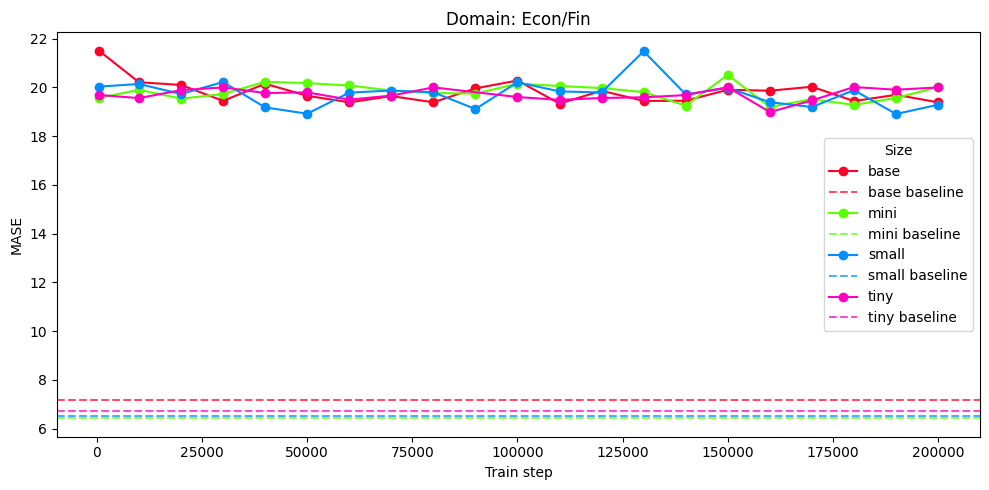

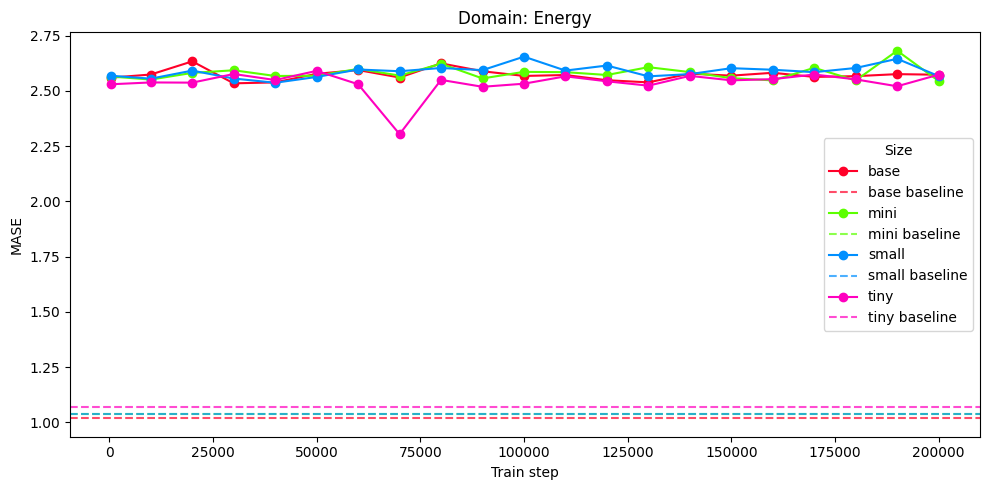

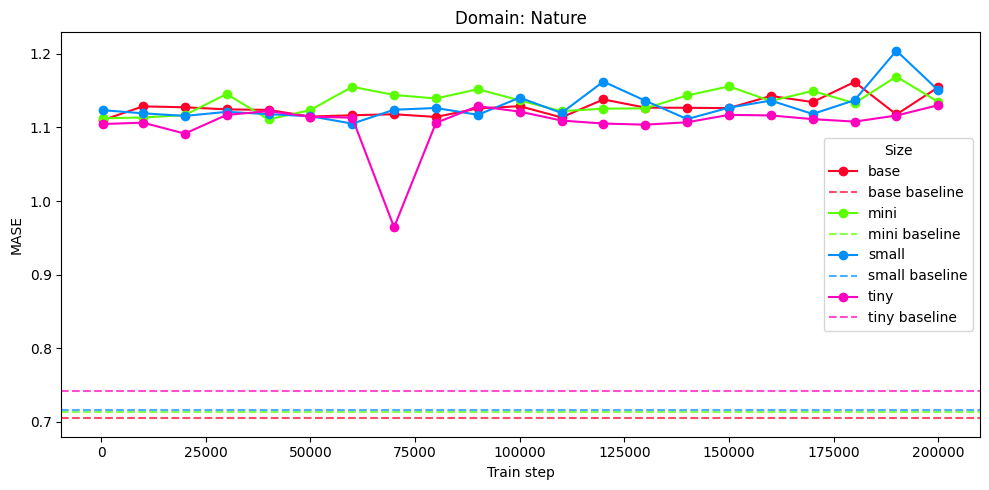

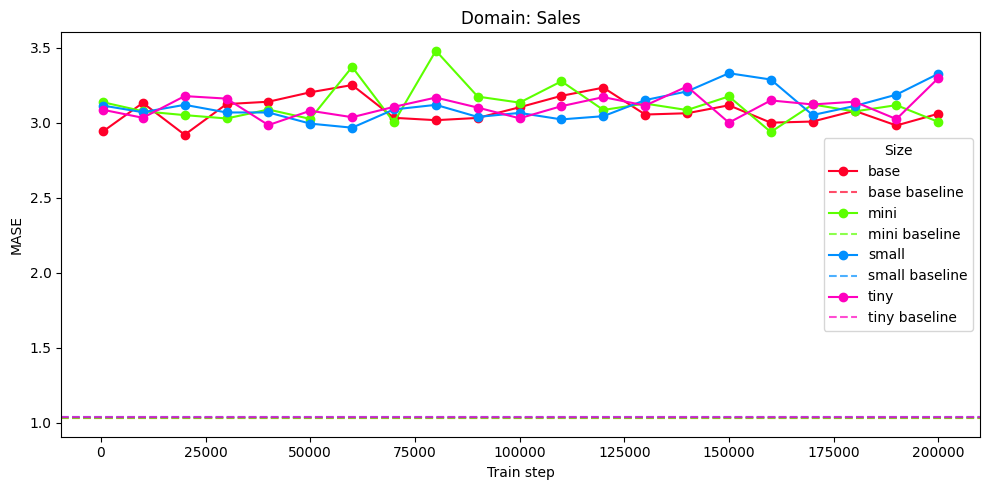

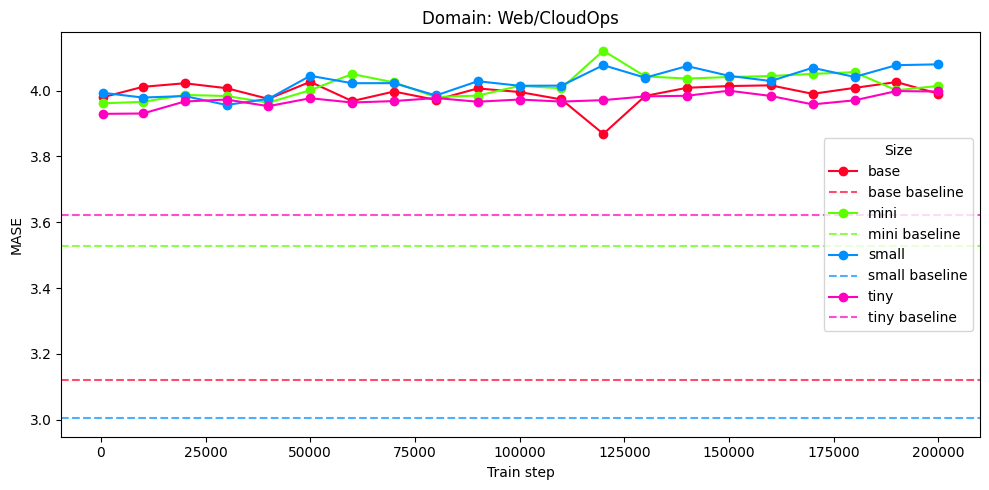

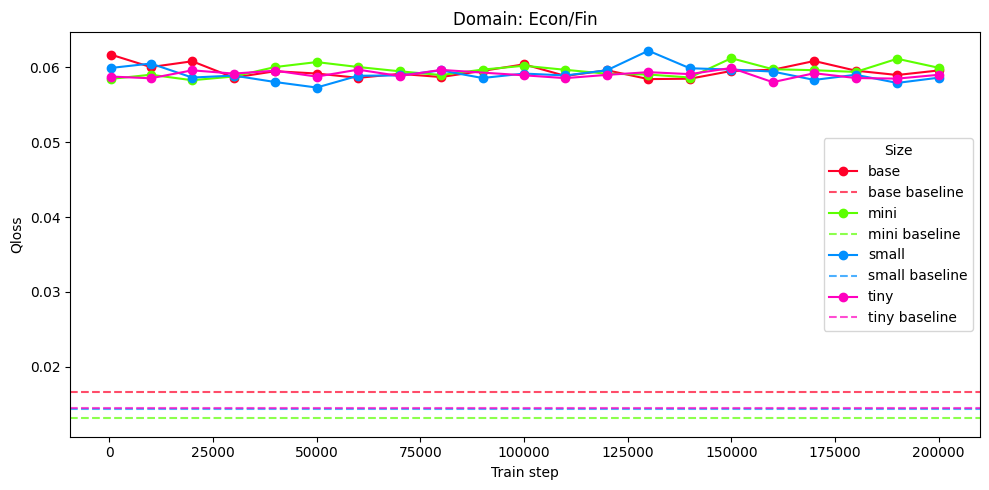

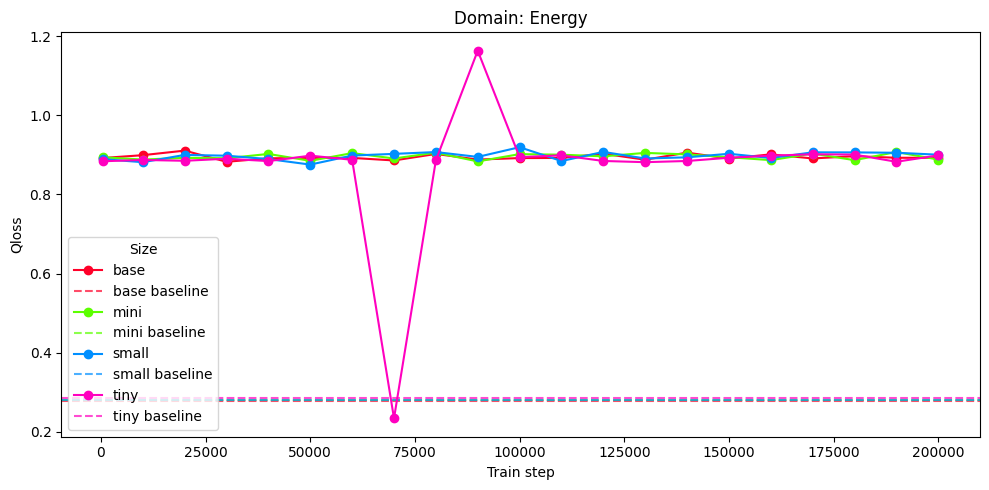

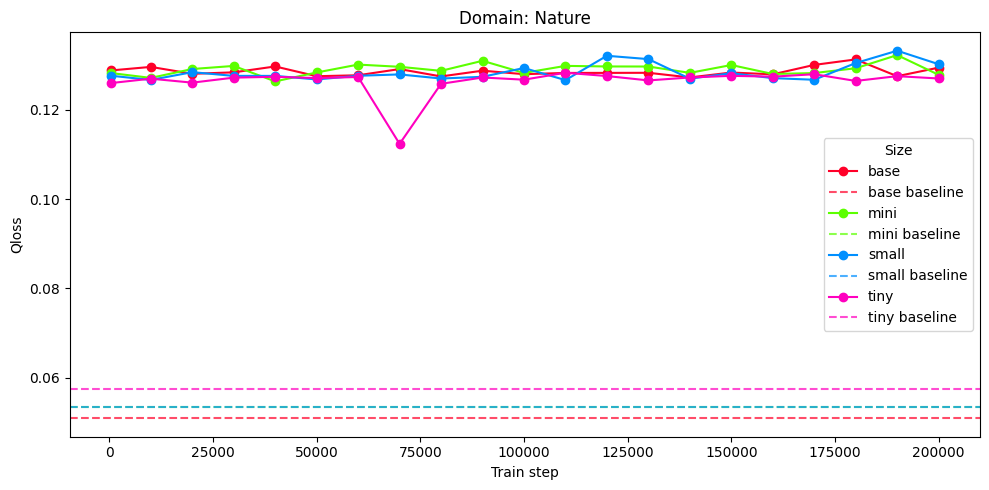

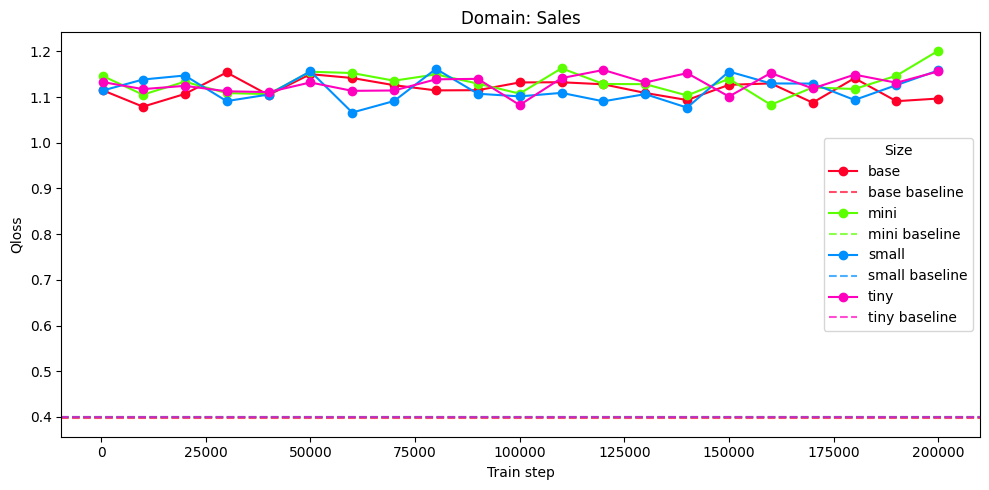

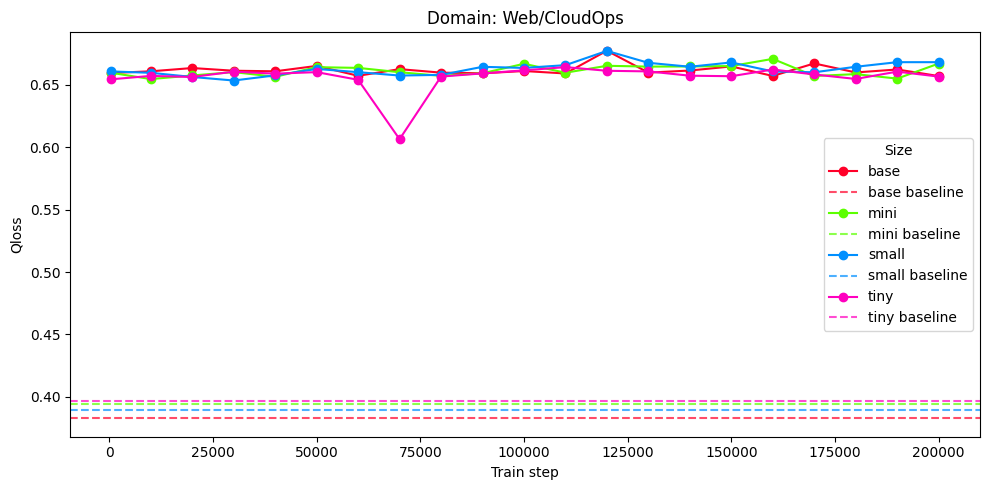

In [32]:
plot_metric_vs_train_step_with_versions(grouped_domain, baseline_domain, group_col="domain",
    metric_cols=["MASE", "Qloss"], title_prefix="Domain")

/tmp/ipykernel_3777924/1993374638.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap("gist_rainbow", len(versions))  # consistent colors


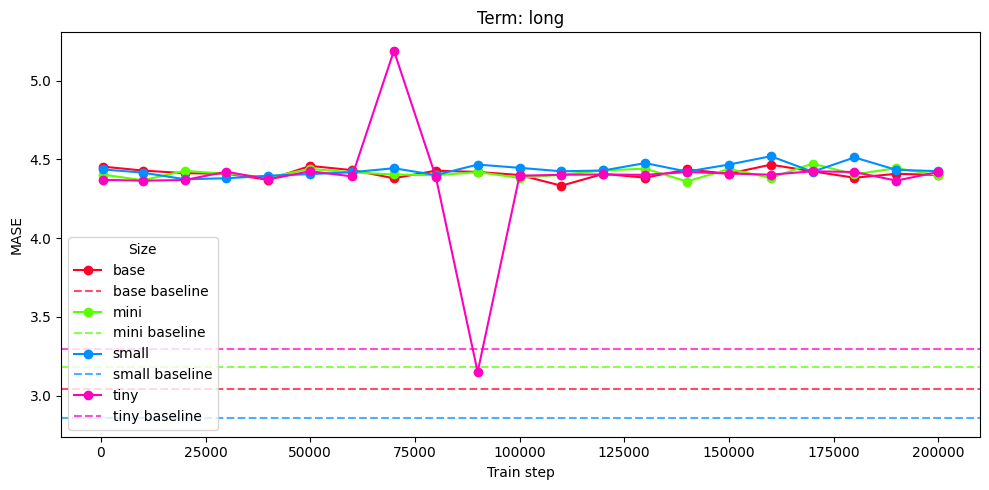

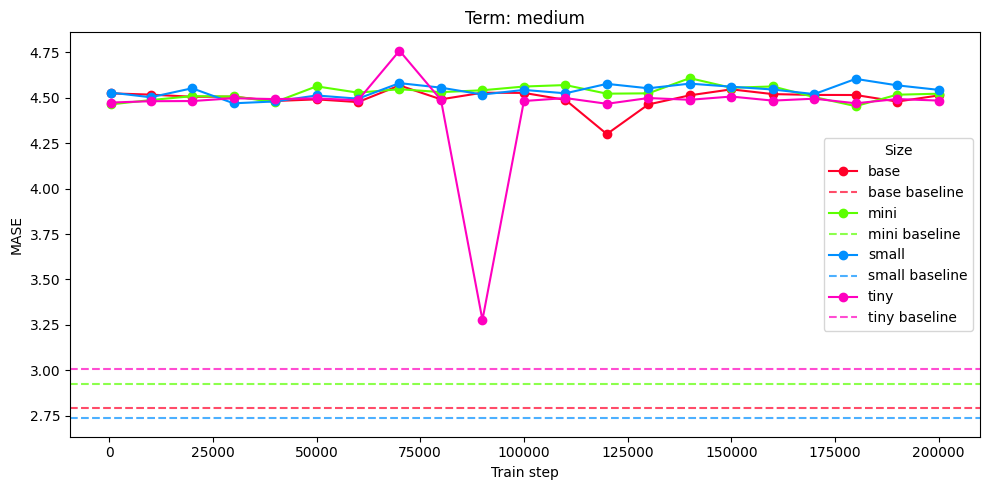

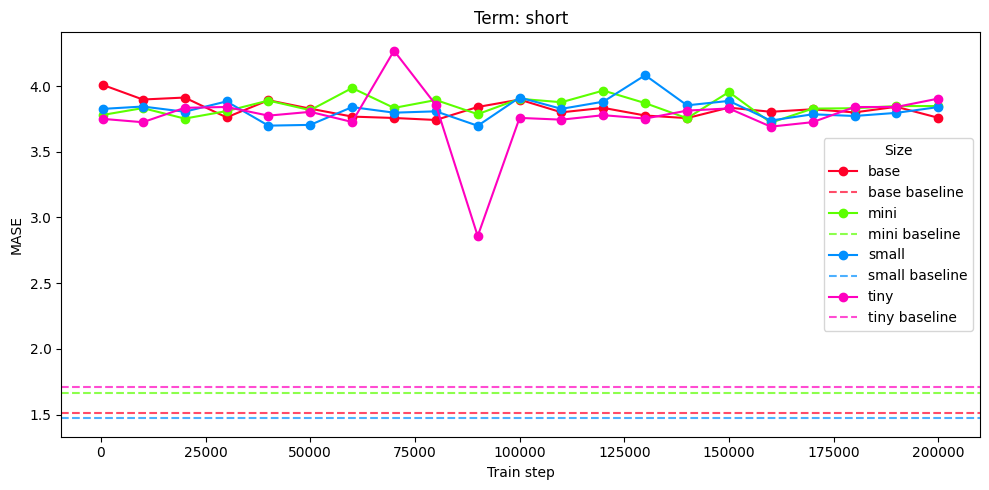

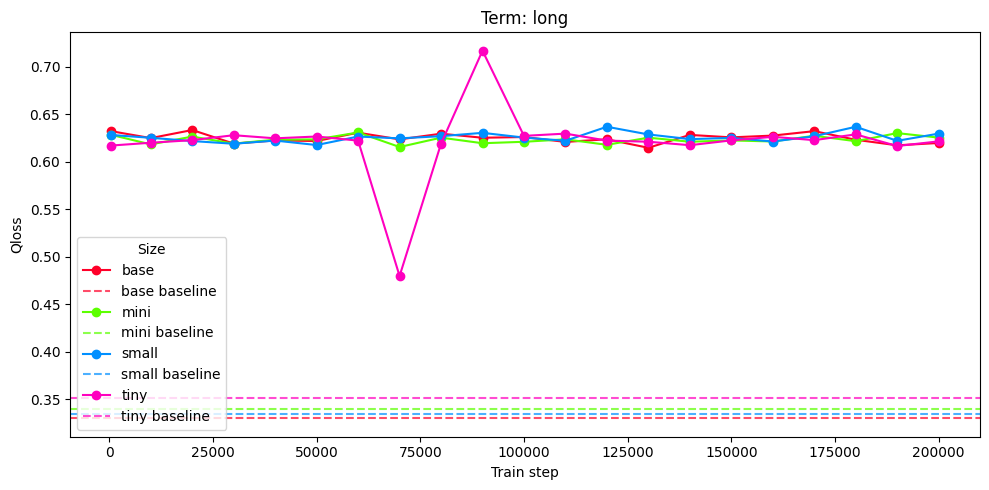

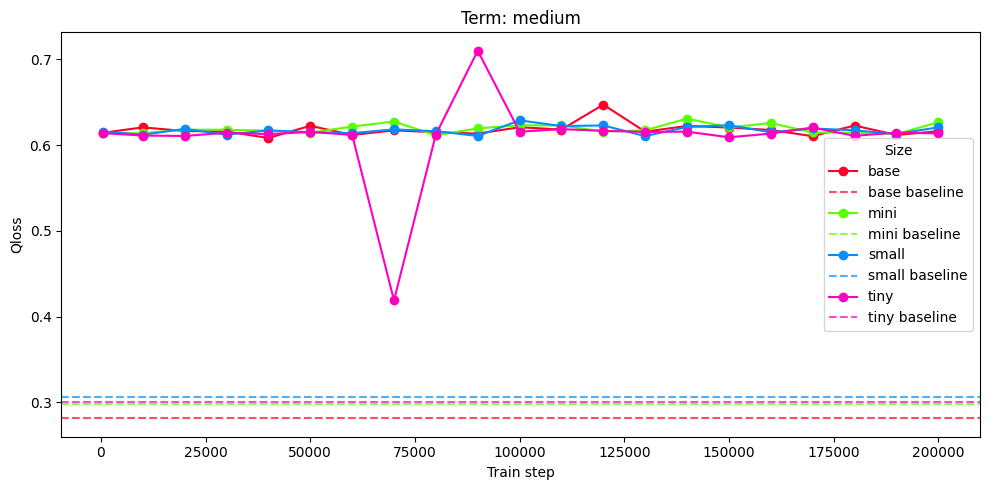

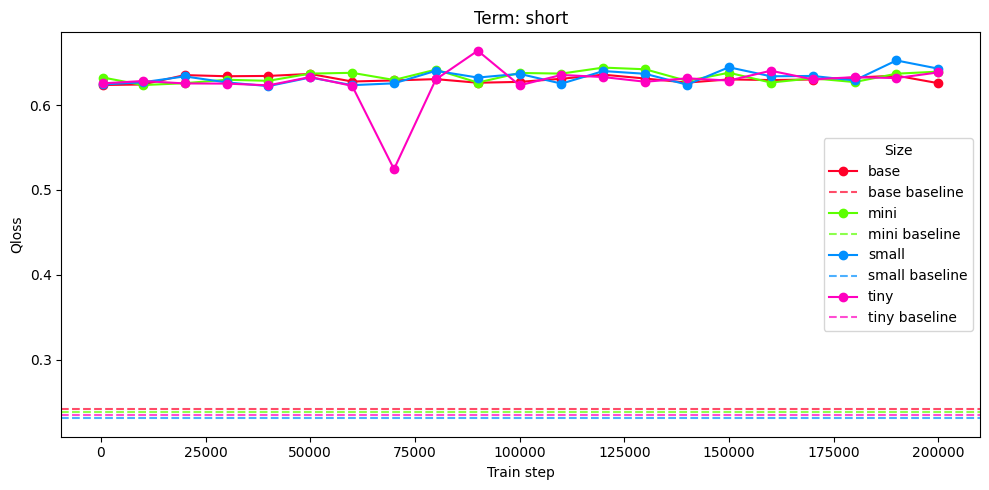

In [33]:
plot_metric_vs_train_step_with_versions(grouped_term, baseline_term, group_col="term",
    metric_cols=["MASE", "Qloss"], title_prefix="Term")

/tmp/ipykernel_3777924/1993374638.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap("gist_rainbow", len(versions))  # consistent colors


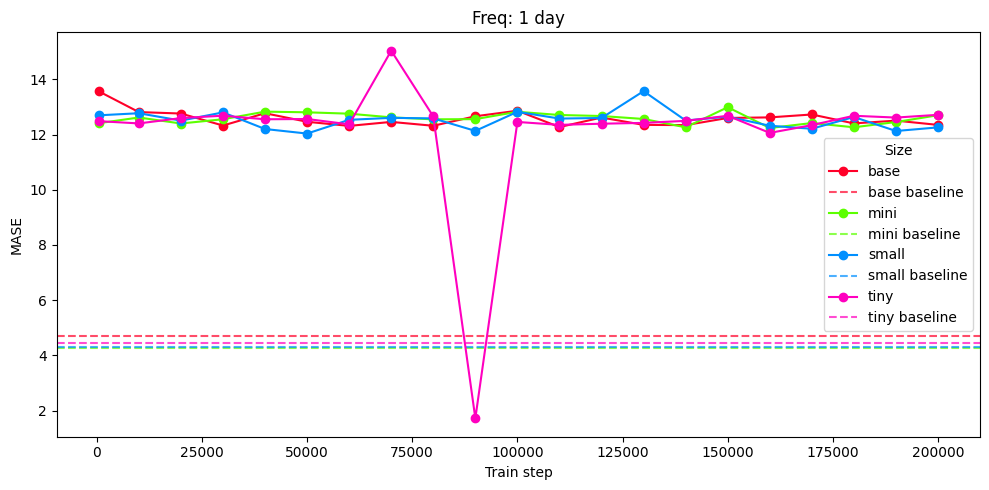

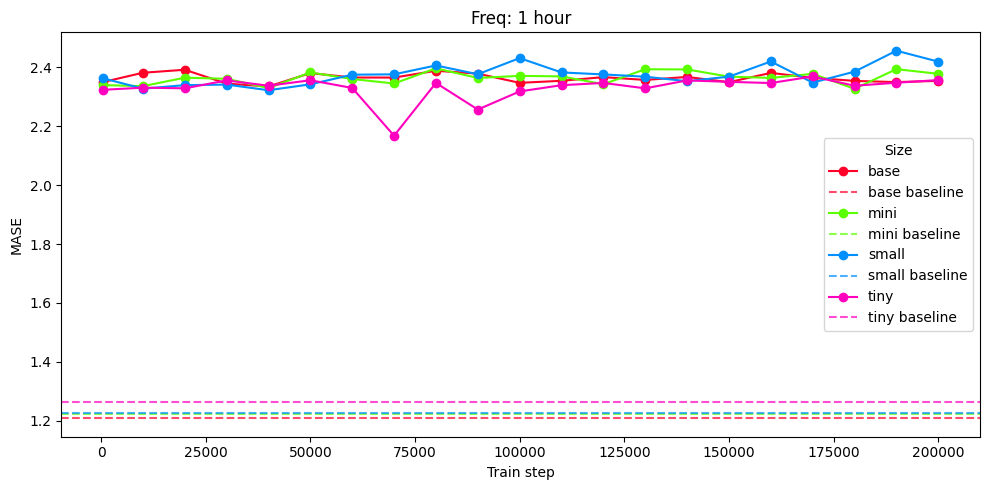

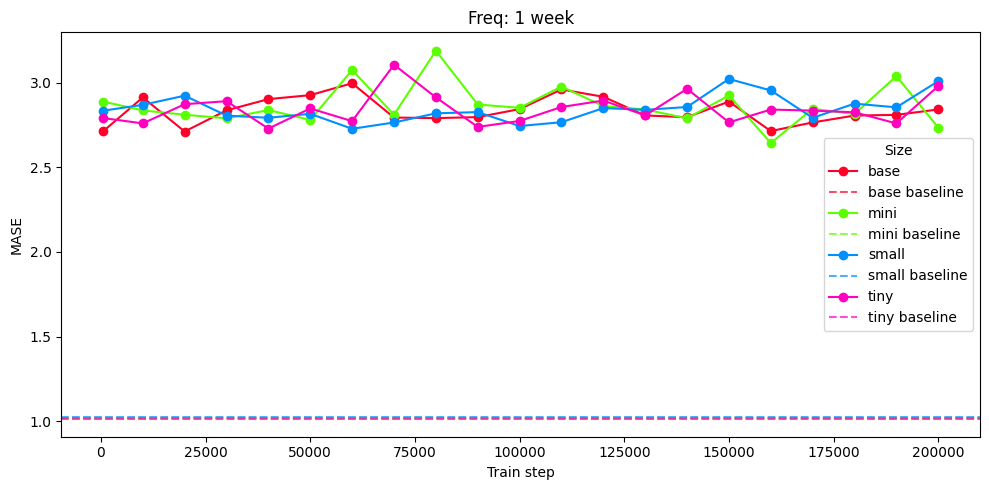

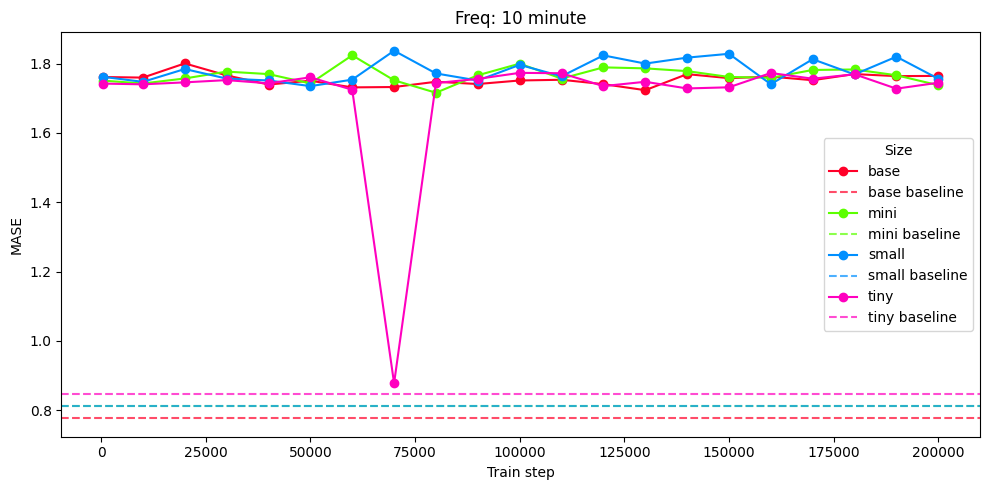

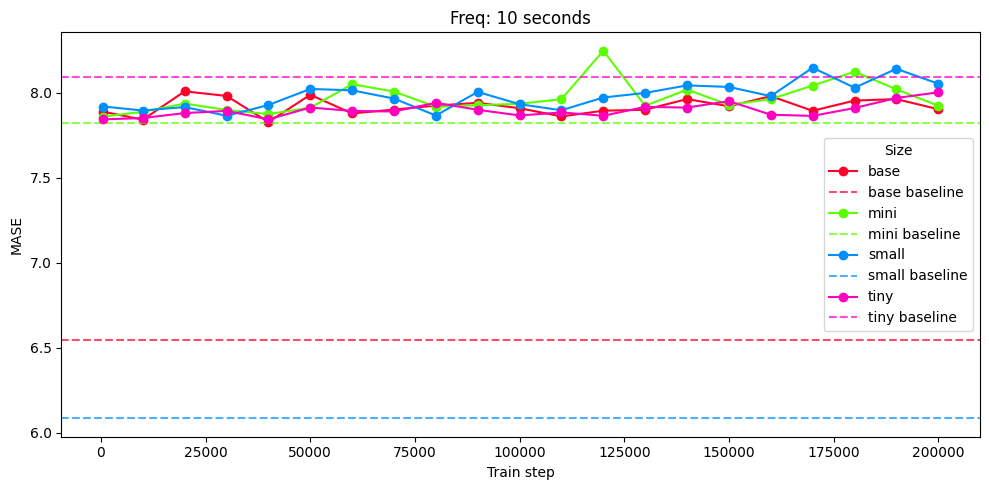

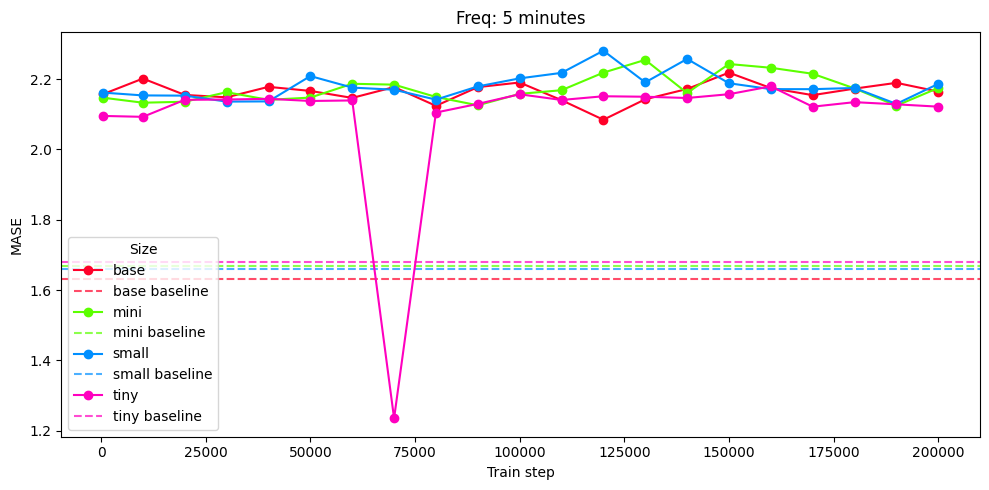

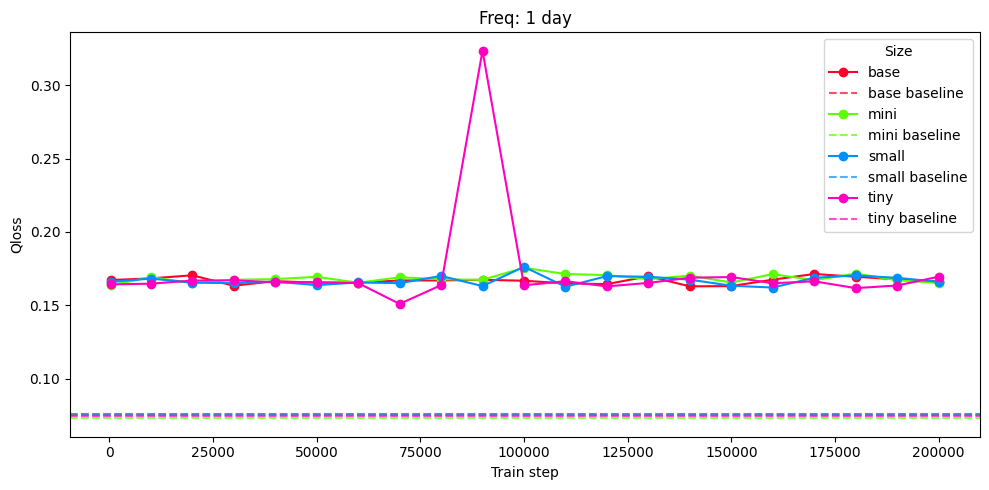

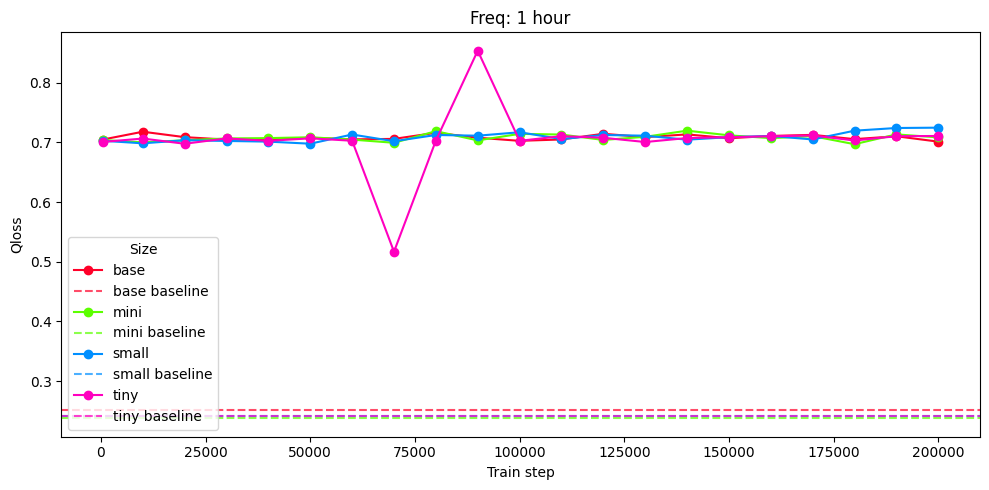

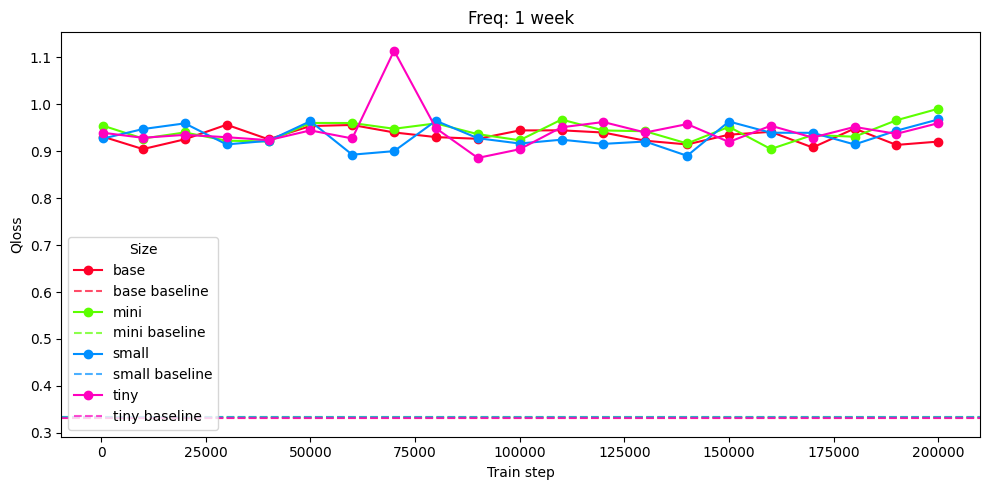

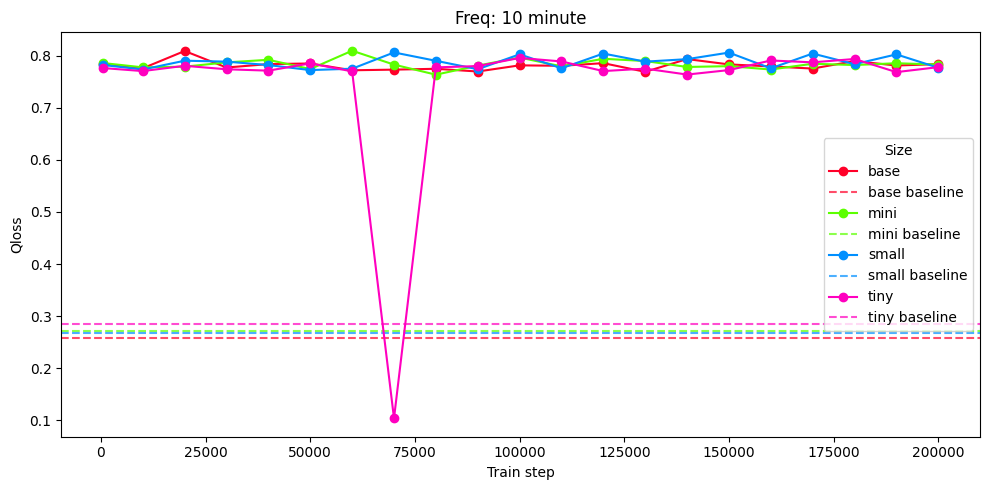

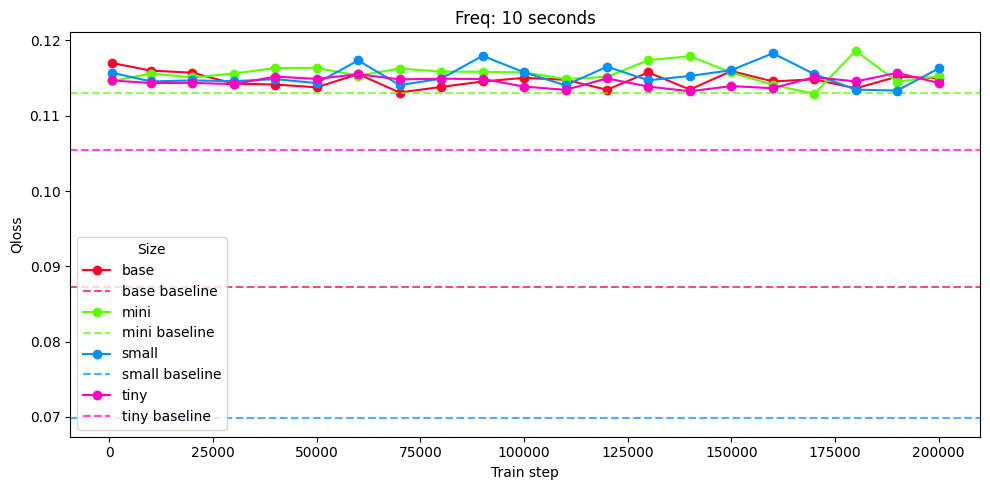

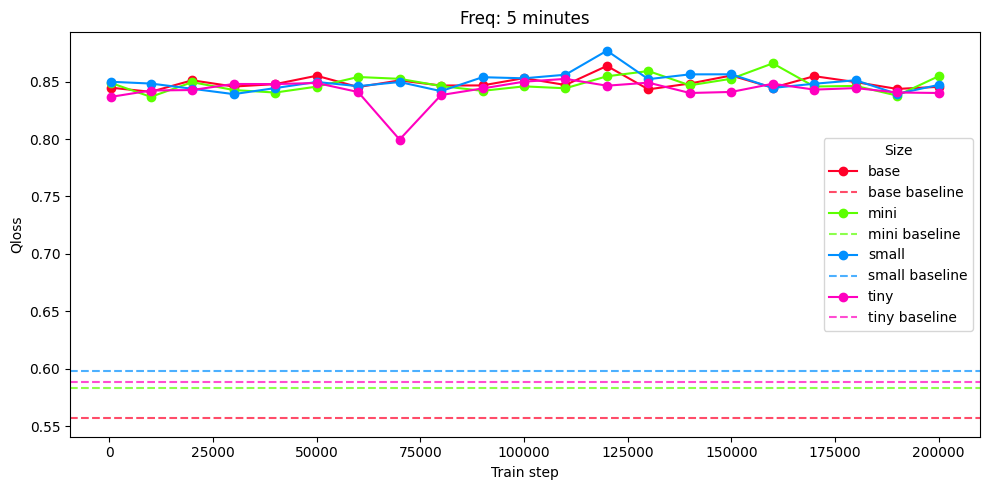

In [34]:
plot_metric_vs_train_step_with_versions(grouped_freq, baseline_freq, group_col="freq",
    metric_cols=["MASE", "Qloss"], title_prefix="Freq")